In [1]:
import os, sys

sys.path.append(os.path.abspath(os.path.join("../..")))  # access sibling directories

from src.python.helpers import area_grid
#from src.python.settings import # TODO: use settings for plots

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from collections import OrderedDict
from ipywidgets import interact
import cartopy.crs as ccrs

2023-09-18 16:38:05.290607: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/ho/code/BayesFlow/bayesflow/trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Loading Simulation Datasets

In [2]:
DIR = '/home/ho/code/climate/sim-data/'
CMIP_folder = 'DB23_CMIP6_files/'
filenames = os.listdir(DIR+CMIP_folder)

In [3]:
[(filenames[i][20:-36]) for i in range(len(filenames))]

['ssp126_MIROC-ES2L',
 'ssp370_IPSL-CM6A-LR',
 'ssp126_MIROC6',
 'ssp245_CanESM5',
 'ssp245_MIROC-ES2L',
 'ssp126_CanESM5',
 'ssp370_ACCESS-ESM1-5',
 'ssp370_GISS-E2-1-G',
 'ssp245_ACCESS-ESM1-5',
 'ssp126_ACCESS-ESM1-5',
 'ssp245_GISS-E2-1-G',
 'ssp370_MIROC-ES2L',
 'ssp245_CNRM-ESM2-1',
 'ssp245_IPSL-CM6A-LR',
 'ssp370_UKESM1-0-LL',
 'ssp126_UKESM1-0-LL',
 'ssp370_CanESM5']

In [4]:
_datasets = OrderedDict((filename[20:-36],xr.open_dataset(DIR+CMIP_folder+filename).rename({'tas':'TAS_F'})) for filename in filenames)

In [5]:
DIR = '/home/ho/code/climate/sim-data/'
CESM_folder = 'CESM/'
CESM_filename = 'b.e21.BHISTsmbb-BSSP370smbb.f09_g17.LE2.cam.h0.TREFHT.185001-210012.r144x72.annual.nc'
cesm_key = 'ssp370_CESM2'

In [6]:
_datasets[cesm_key] = xr.open_dataset(DIR+CESM_folder+CESM_filename).rename({'__xarray_dataarray_variable__':'TAS_F'})

Let us take a look at the data we just loaded.

<class 'cartopy.mpl.geocollection.GeoQuadMesh'>


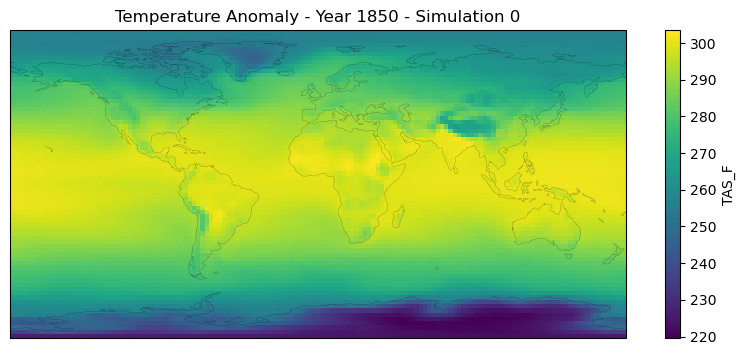

In [7]:
#@interact
def show_map( model=list(_datasets.keys()), year=(1850, 2100, 1), member=(0, 9, 1)):
    plt.figure(figsize=(10, 4))
    f = (_datasets[model].sel(member=0, time=str(year)).TAS_F
         ).plot(
        subplot_kws=dict(projection=ccrs.PlateCarree(central_longitude=0.0), facecolor="gray"),
        transform=ccrs.PlateCarree(),
    )
    print(type(f))
    #f.set_clim(-10, 10)
    f.axes.set_global()
    f.axes.set_title(f'Temperature Anomaly - Year {year} - Simulation {member}')
    f.axes.coastlines(linewidth=0.1)
show_map(model=cesm_key, year=1850, member=0)

In [8]:
[len(xi.member) for xi in _datasets.values()]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 40]

Almost all models have 10 realizations of timeseries. The exception is CESM, which has 4 timeseries. 

For CESM each ensemble of 10 stems from a similar IC, see [description of the CESM-LENS2](https://www.cesm.ucar.edu/community-projects/lens2). It follows that the variance within an ensemble is due to chaos and the corresponding uncertainty is irreducible. In contrast, across ensemble variability includes a significant additional spread of initial conditions chosen to sample different phases of the Atlantic meridional overturning circulation.

Thus, we group data into ensembles of 10 timeseries such that CESM has four ensembles and the rest has just one.

# Preprocessing all datasets

For further use, we are interested in derived quantities from these timeseries.

We need
* to calculate the area-weighted mean of temperature
* to associate the temperature map of each point in time in each timeseries with the year when that global and ensemble-wide temperature mean exceeds some threshold
* a way to look up all temperature maps that are $\theta$ years before their simulations exceed some threshold

We start by defining helper functions for calculating the area of each grid point. The data comes on a longitude-lattitude grid. Thus, the areas of the grid points varies substantially. 


In [9]:
RESOLUTION_LAT, RESOLUTION_LON = 72, 144

Now we can bring it all together in a unified data structure. Each Climate Model will have its own xarray.Dataset object.  

In [10]:
datasets = OrderedDict()

for key in sorted(_datasets.keys()):
    print(key)
    model, scenario = key[7:], key[:6]
    ds = _datasets[key]
    ds = ds.rename({'TAS_F':'TAS', 'lat':'latitude', 'lon':'longitude', 'time':'year'})
    ds['year'] = ds.year.dt.year
    ds.attrs={
        'description': f"Coupled Climate Model Simulation {key[7:]}, in scenario {key[:6]}, Surface Air Temperature at Reference Height",
    }

    assert ds.latitude.shape[0] == RESOLUTION_LAT
    assert ds.longitude.shape[0] == RESOLUTION_LON

    if key==cesm_key:
        # We split the 40 members in their respective simulations indexed by the piControl year that supplies the initial conditions
        tas_values = ds.TAS.values.reshape(4, 10, 251, 72, 144)
        ensemble_id = [f'{model}|{scenario}|{num}' for num in [1231, 1251, 1281, 1301]]
        # crop to make member dimension length 10
        ds = ds.isel(member=list(range(10)))
    else:
        tas_values = ds.TAS.values[None,:]
        ensemble_id =  [f'{model}|{scenario}|{0}']

    # Build DataArray for surface temperature
    xtemp = xr.DataArray(
        tas_values - 273.15, # temperature in °C
        dims=["ensemble", "member", "year", "latitude", "longitude"],
        coords={"latitude": ds.latitude, "longitude": ds.longitude, "ensemble": ensemble_id, "member": np.arange(10), "year": np.arange(1850,2101)},
        attrs={
            "long_name": "surface_temperature",
            "description": "Surface Air Temperature at Reference Height",
            "units": "°C",
        },
    )
    
    ds = ds.assign({'TAS': xtemp})
    
    # Calculate area of each grid cell
    xda = area_grid(ds.latitude, ds.longitude)
    ds = ds.assign({'AREA': xda})

    # Calculate global mean temperature DataArray with correct area weighting
    xgt = (ds.TAS * ds.AREA / ds.AREA.sum(dim=('latitude','longitude'))).sum(dim=('latitude','longitude'))
    xgt.attrs = {
                'long_name': 'global_mean_surface_temperature',
                'description': 'Global Mean of Surface Air Temperature',
                'units': '°C'}
    ds = ds.assign({'TAS_global': xgt})
    
    # Calculate baseline temperature of the period 1951 to 1980 to ease comparison of different climate models
    xgt_baseline = ds.TAS_global.sel(year=slice(1951,1980)).mean(dim=('year', 'ensemble', 'member'))
    xgt_baseline.attrs = {
                'long_name': 'global_mean_surface_temperature_baseline',
                'description': 'Global Mean of Surface Air Temperature for the period 1951 to 1980',
                'units': '°C'}
    ds = ds.assign({'TAS_global_baseline': xgt_baseline})
    
    
    # Determine the year when the global mean temperature of each ensemble exceeds a threshold
    def detect_threshold(dataset, threshold):
        sim_mean_global_temp = dataset.TAS_global.mean(dim='member')
        pre_industrial = dataset.TAS_global[:, :, :50].mean(dim=('ensemble', 'member', 'year'))
        cond = sim_mean_global_temp - pre_industrial > threshold
        return cond.idxmax(dim='year')
    
    # For a number of interesting thresholds, add threshold-passing year to each ensemble
    pass_dict = {}
    for thres in [1.1, 1.5, 2, 3]: 
        threshold_key = f'pass_{int(thres*10)}'
        pass_dict[threshold_key] = detect_threshold(ds, thres)
        pass_dict[threshold_key].attrs = {
                "long_name": f'year_mean_temp_passes_{thres:.1f}C',
                "description": f"Year when global mean temperature anomaly exceeds {thres:.1f} °C",
                "units": "year",
            }
    ds = ds.assign(pass_dict)
    
    datasets[key] = ds

ssp126_ACCESS-ESM1-5
ssp126_CanESM5
ssp126_MIROC-ES2L
ssp126_MIROC6
ssp126_UKESM1-0-LL
ssp245_ACCESS-ESM1-5
ssp245_CNRM-ESM2-1
ssp245_CanESM5
ssp245_GISS-E2-1-G
ssp245_IPSL-CM6A-LR
ssp245_MIROC-ES2L
ssp370_ACCESS-ESM1-5
ssp370_CESM2
ssp370_CanESM5
ssp370_GISS-E2-1-G
ssp370_IPSL-CM6A-LR
ssp370_MIROC-ES2L
ssp370_UKESM1-0-LL


# Take a look at the result
This is how the dataset looks like for the Community Earth System Model.

In [11]:
datasets['ssp370_CESM2'].isel(member=list(range(10)))

<xarray.Dataset>
Dimensions:              (year: 251, member: 10, longitude: 144, latitude: 72,
                          ensemble: 4)
Coordinates:
  * year                 (year) int64 1850 1851 1852 1853 ... 2098 2099 2100
  * member               (member) int64 0 1 2 3 4 5 6 7 8 9
  * longitude            (longitude) float64 0.0 2.5 5.0 ... 352.5 355.0 357.5
  * latitude             (latitude) float64 -88.75 -86.25 -83.75 ... 86.25 88.75
  * ensemble             (ensemble) <U17 'CESM2|ssp370|1231' ... 'CESM2|ssp37...
Data variables:
    TAS                  (ensemble, member, year, latitude, longitude) float64 ...
    AREA                 (latitude, longitude) float64 1.678e+09 ... 1.678e+09
    TAS_global           (ensemble, member, year) float64 14.17 14.09 ... 18.86
    TAS_global_baseline  float64 14.31
    pass_11              (ensemble) int64 2013 2017 2015 2013
    pass_15              (ensemble) int64 2030 2030 2029 2029
    pass_20              (ensemble) int64 2045 2043 2044 2043
    pass_30              (ensemble) int64 2068 2068 2067 2068
Attributes:
    description:  Coupled Climate Model Simulation CESM2, in scenario ssp370,...

# Save all datasets to disk

In [12]:
for key in datasets.keys():
    print(key)
    datasets[key].to_netcdf(f'{DIR}preproc/tas_anual_preproc_{key}.nc')

ssp126_ACCESS-ESM1-5
ssp126_CanESM5
ssp126_MIROC-ES2L
ssp126_MIROC6
ssp126_UKESM1-0-LL
ssp245_ACCESS-ESM1-5
ssp245_CNRM-ESM2-1
ssp245_CanESM5
ssp245_GISS-E2-1-G
ssp245_IPSL-CM6A-LR
ssp245_MIROC-ES2L
ssp370_ACCESS-ESM1-5
ssp370_CESM2
ssp370_CanESM5
ssp370_GISS-E2-1-G
ssp370_IPSL-CM6A-LR
ssp370_MIROC-ES2L
ssp370_UKESM1-0-LL


# How to load the preprocessed simulation data

In [13]:
X = xr.open_dataset(f'{DIR}preproc/tas_anual_preproc_ssp370_CESM2.nc')
X

<xarray.Dataset>
Dimensions:              (year: 251, member: 10, longitude: 144, latitude: 72,
                          ensemble: 4)
Coordinates:
  * year                 (year) int64 1850 1851 1852 1853 ... 2098 2099 2100
  * member               (member) int64 0 1 2 3 4 5 6 7 8 9
  * longitude            (longitude) float64 0.0 2.5 5.0 ... 352.5 355.0 357.5
  * latitude             (latitude) float64 -88.75 -86.25 -83.75 ... 86.25 88.75
  * ensemble             (ensemble) object 'CESM2|ssp370|1231' ... 'CESM2|ssp...
Data variables:
    TAS                  (ensemble, member, year, latitude, longitude) float64 ...
    AREA                 (latitude, longitude) float64 ...
    TAS_global           (ensemble, member, year) float64 ...
    TAS_global_baseline  float64 ...
    pass_11              (ensemble) int64 ...
    pass_15              (ensemble) int64 ...
    pass_20              (ensemble) int64 ...
    pass_30              (ensemble) int64 ...
Attributes:
    description:  Coupled Climate Model Simulation CESM2, in scenario ssp370,...

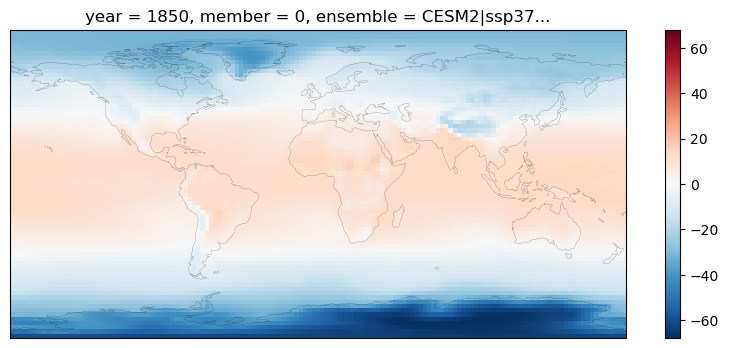

In [14]:
plt.figure(figsize=(10, 4))
f = (X.TAS - X.TAS_global).isel(ensemble=0).sel(member=0, year=1850).plot(
        subplot_kws=dict(projection=ccrs.PlateCarree(central_longitude=0.0), facecolor="gray"),
        transform=ccrs.PlateCarree(),
    )
f.axes.set_global()
f.axes.coastlines(linewidth=0.1)

# How to retrieve temperature map for a given time to threshold

In [15]:
def get_var_from_time_to_threshold(ds, var, threshold, time):
    assert type(time) == int
    assert time >= -50 and time <= 250
    assert threshold in [1.1, 1.5, 2.0, 3.0]
    assert var in ds
    tds = ds.stack(ensemble_member=('ensemble', 'member'))
    tidx = (tds[f'pass_{int(threshold*10)}'] - tds.year == time).idxmax(dim='year')
    return tds[var].loc[{'year': tidx}].unstack('ensemble_member')

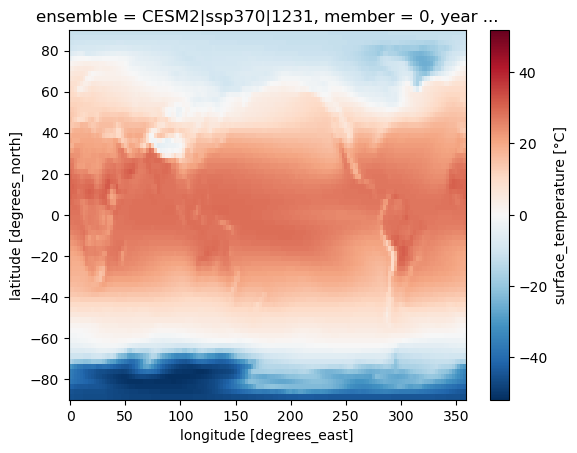

In [16]:
# test retrieval of variables given a threshold and a number of years until that threshold is reached
get_var_from_time_to_threshold(X, 'TAS', 1.5, 10).isel(ensemble=0).sel(member=0).plot()

# How to plot maps

In [17]:
import cartopy.crs as ccrs
tds = ds.stack(ensemble_member=('ensemble', 'member'))

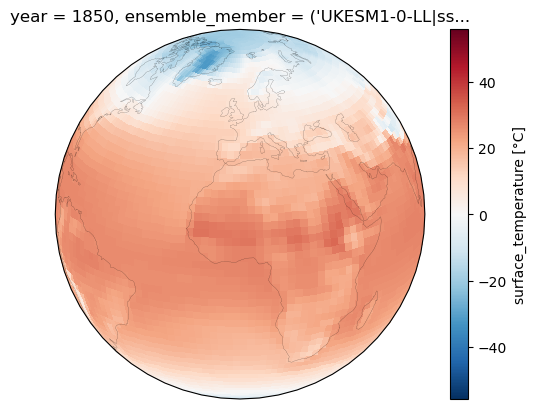

In [18]:
f = tds.isel(year=0, ensemble_member=0).TAS.plot(
    subplot_kws=dict(projection=ccrs.Orthographic(0, 20), facecolor="gray"),
    transform=ccrs.PlateCarree(),
)
f.axes.set_global()
f.axes.coastlines(linewidth=0.1)

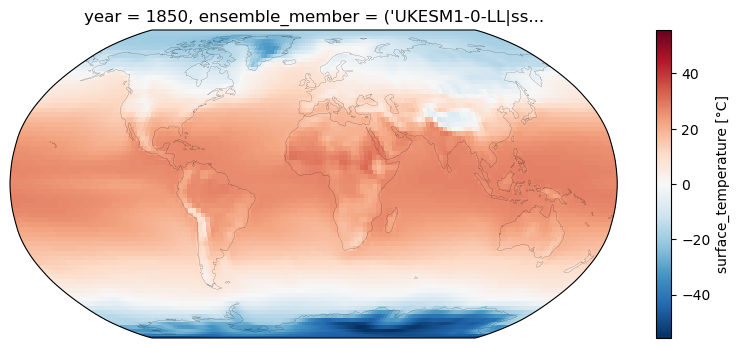

In [19]:
plt.figure(figsize=(10, 4))
f = tds.isel(year=0, ensemble_member=0).TAS.plot(
    subplot_kws=dict(projection=ccrs.Robinson(central_longitude=0.0), facecolor="gray"),
    transform=ccrs.PlateCarree(),
)
f.axes.set_global()
f.axes.coastlines(linewidth=0.1)

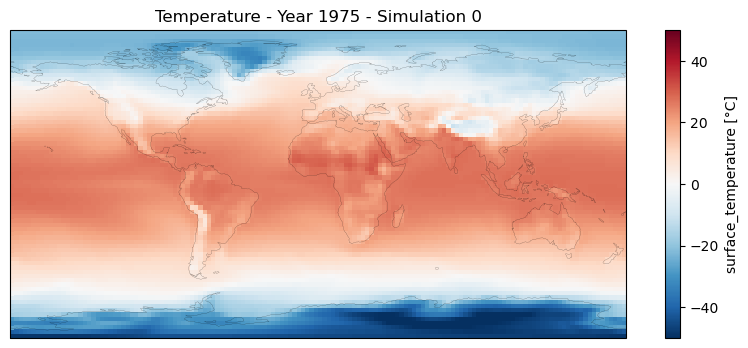

In [20]:
#@interact
def show_map(year=(1850, 2100, 1), ensemble_member=(0, 9, 1)):
    plt.figure(figsize=(10, 4))
    f = tds.sel(year=year).isel(ensemble_member=ensemble_member).TAS.plot(
        subplot_kws=dict(projection=ccrs.PlateCarree(central_longitude=0.0), facecolor="gray"),
        transform=ccrs.PlateCarree(),
    )
    f.set_clim(-50, 50)
    f.axes.set_global()
    f.axes.set_title(f'Temperature - Year {year} - Simulation {ensemble_member}')
    f.axes.coastlines(linewidth=0.1)
show_map(year=1975, ensemble_member=0)